In [1]:
from pipeline.service import FileService
cleaned_df = FileService.read_parquet_to_df(file_name='articles_cleaned')
de_df = cleaned_df[cleaned_df['language'] == 'de'].iloc[:40]

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import numpy as np
import os
from sentence_transformers import SentenceTransformer
from pipeline.service import FileService

cleaned_df = FileService.read_parquet_to_df(file_name='articles_cleaned')

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(list(cleaned_df["content"]), show_progress_bar = True)
embeddings.shape

np.save(arr=embeddings, file=os.path.normpath("./models/vectorspaces/jan-jun-2020-embeddings.npy"))

/home/vscode/.local/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Batches:   0%|          | 0/737 [00:00<?, ?it/s]

In [5]:
import numpy as np
import os
embeddings = np.load(file=os.path.normpath("./models/vectorspaces/jan-jun-2020-embeddings.npy"))
embeddings.shape

(23555, 768)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#x_scaled = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=3, )
pca_features = pca.fit_transform(embeddings)

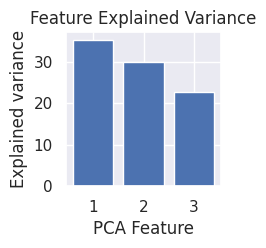

In [19]:
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
sns.set()

# Bar plot of explained_variance
matplotlib.rc('figure', figsize=(2, 2))
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )


plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

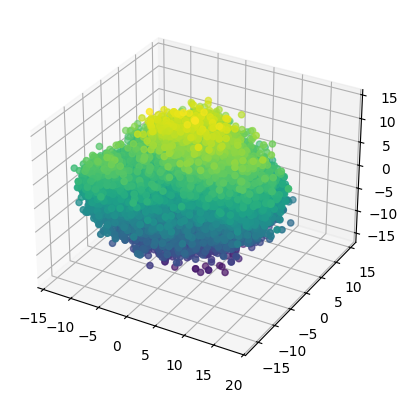

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# Prepare 3D graph
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot scaled features
xdata = pca_features[:,0]
ydata = pca_features[:,1]
zdata = pca_features[:,2]

# Plot 3D plot
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis')

plt.show()

In [21]:
max([max(e) for e in x_scaled])

7.366181

In [22]:
min([min(e) for e in x_scaled])

-4.6272044

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = list(range(2, 83, 5))

cluster_labels = []
for n_clusters in range_n_clusters:
    print(f"working on {n_clusters}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels.append(kmeans.fit_predict(embeddings))


working on 2
working on 7
working on 12
working on 17
working on 22
working on 27
working on 32
working on 37
working on 42
working on 47
working on 52
working on 57
working on 62
working on 67
working on 72
working on 77
working on 82


In [33]:
cluster_labels

array([4, 2, 3, 4, 1, 0, 3, 3, 1, 4, 1, 4, 4, 4, 3, 4, 4, 5, 2, 4, 4, 4,
       4, 1, 3, 4, 5, 5, 3, 1, 0, 1, 1, 3, 3, 2, 3, 5, 4, 5], dtype=int32)

In [23]:
#silhouette_avg = silhouette_score(embeddings, cluster_labels, )
#silhouette_avg

sil_avg = [silhouette_score(embeddings, labels) for labels in cluster_labels]
sil_avg

[0.025004135,
 0.032578506,
 0.031506028,
 0.03022785,
 0.030104501,
 0.028246531,
 0.031726923,
 0.028404173,
 0.030772172,
 0.029758895,
 0.028155876,
 0.029762654,
 0.0293596,
 0.029651811,
 0.02960189,
 0.02952846,
 0.029739868]

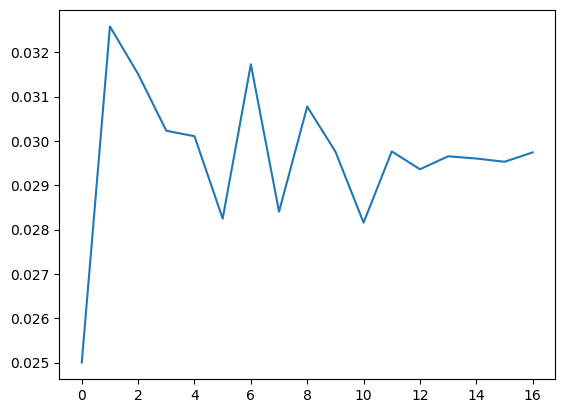

In [24]:
import matplotlib.pyplot as plt
plt.plot(sil_avg)

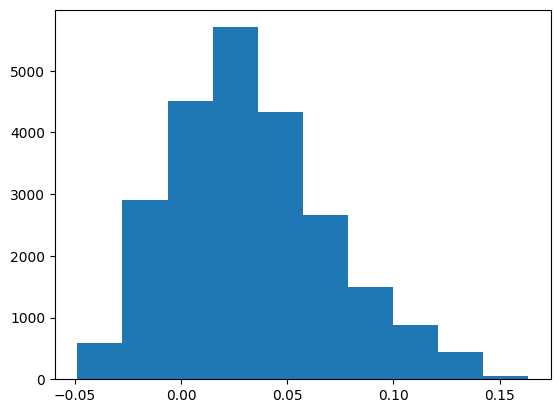

In [13]:
plt.hist(silhouette_samples(embeddings, cluster_labels))
sil_samples = silhouette_samples(embeddings, cluster_labels)

In [53]:
cutoff = 0.2
for idx, value in enumerate(sil_samples.tolist()):
    if value > cutoff:
        print(f"Cluster {cluster_labels[idx]}")
        print(list(de_df["content"])[idx])

Cluster 0
 Der Unfall ereignete sich kurz vor 0.30 Uhr am Montag auf der Strecke zwischen Büron LU und Schmiedrued AG im Gebiet Rehhag. Ein 21-jähriger Schweizer fuhr mit «nicht angepasster Geschwindigkeit», wie die Kantonspolizei Aargau berichtete. Zudem wurden dem Fahrer die Strassenverhältnisse zum Verhängnis. In einer Kurve kam er mit seinem Opel Corsa ins Schleudern und fuhr gegen ein Strassenbord, worauf sich das Auto mehrmals überschlug. Bei dem Unfall wurde der Fahrer leicht verletzt und mit der Ambulanz ins Spital gefahren. Am Auto entstand grosser Sachschaden, wie die Kapo Aargau mitteilt. 
Cluster 5
 In einem Brief an den schottischen Fussballverband hat Brian Rice, Trainer beim Erstligisten Hamilton Academical, zugegeben, gegen das Glücksspielgesetz verstossen zu haben. Der 56-Jährige, der schon in der Vergangenheit mit Spielsucht zu kämpfen hatte, hat sich selbst angezeigt. «Ich kann nicht glauben, dass ich wieder im Griff dieser Krankheit bin», sagte Rice in einem ausführ

In [52]:
print(sum(cluster_labels == 0), sum(cluster_labels == 5))

2 5


In [58]:
cluster_articles = [list(de_df["content"])[idx] for idx, label in enumerate(cluster_labels) if label == 5]
for c in cluster_articles:
    print(c)

 Wie die britische Zeitung «The Guardian» berichtete, ist Chloe Middleton am 21. März in ihrem Heimatort High Wycombe westlich von London verstorben. Ihre Familie war sich sicher, dass Chloe am Coronavirus starb. Auf Facebook warnt ihre Mutter darauf vor den Gefahren des Virus. Auch junge Menschen sollten das Coronavirus nicht unterschätzen. «An alle Leute da draussen, die glauben, dass es sich nur um ein Virus handelt, denkt noch einmal darüber nach. Das Virus hat meiner 21-jährigen Tochter das Leben genommen», schreibt Diane Middleton auf Facebook. Laut Chloes Tante Emily Mistry war die junge Frau völlig gesund und hatte keinerlei Vorerkrankungen. Chloes Familie leide gerade «unter den unvorstellbarsten Schmerzen», erklärte Mistry gegenüber dem «Guardian». Inzwischen hat der «Guardian» selbst Zweifel an der Todesursache eingeräumt. Die Ärzte seien überrascht gewesen, dass die Familie vom Coronavirus als Todesursache ausgeht. Ihr Tod ist nicht in der offiziellen Corona-Statistik erfas